In [1]:
import glob, os, json, random
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft,fftfreq
import numpy as np
FOLDER = "initial_wav"
MOD_FOLDER = "FILES_TO_DECODE"
MODULATION_FREQ = 12000
import csv

# Fonctions de modulation & démodulation d'un son

In [3]:
def load_wav_file(fname):
    """
    Charge une partie un son wav. Si stéréo, on ne garde qu'un canal.
    
    PARAMETERS
    -----------
    fname : str
        filenam of the wav file
    """
    rate, data = wavfile.read(fname)
    # suppress stereo : keep only left channel (or right I do not know)
    if len(data.shape)==2:
        data = data[:,0] 
    return rate, data

def modulate(signal, sample_rate, modulation_freq):
    """
    Module un signal par AM à la fréquence de moudlation choisie. 

    PARAMETERS
    -----------
    signal : array
        signal to be modulated
    sample_rate: int
        number of points per second in the audio
    modulation_freq: float
        modulation frequency in hertz (or that should match the unit of the sample rate)
    """
    if modulation_freq > 0.5 * sample_rate:
        print(f"WARNING : the modulation freq {modulation_freq} is too high with respect to sample rate.")
    time = np.arange(0, len(signal)/sample_rate,1/sample_rate)
    return signal *np.sin(2 * np.pi * modulation_freq * time)

def demodulate(signal, sample_rate, modulation_freq, bandwidth):
    """
    Demodule the signal at frequency modulation_freq and filter out 
    frequency higher than the bandwidth. 

    PARAMETERS
    -----------
    signal : array
        signal to be demodulated
    sample_rate : int
        number of points per second in the audio
    modulation_freq: float
        modulation frequency in hertz (or that should match the unit of the sample rate)
    bandwidth: float
        width of the filter to be applied once datas are demodulated. Should
        be in hertz (or should match the unit of the sample rate)
    """
    time = np.arange(0, len(signal)/sample_rate,1/sample_rate)
    signal = signal*np.sin(2 * np.pi * modulation_freq * time)
    fft_signal = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(signal), d=1/sample_rate)
    mask = np.where(np.abs(fft_freq) < bandwidth, 1, 0) # mask to apply filter
    fft_signal = fft_signal * mask # apply filter
    demod_signal = np.fft.ifft(fft_signal)
    return demod_signal

# Modulation de tous les sons dossier initial
Dans le code ci-dessous, on parcourt l'ensemble des fichiers wav du dossier *initial_files*, qu'on va moduler à 12 kHz avant de les sauvegarder dans le dossier *modulated_files* sous un nom inconnu *am_son_03.wav* par exemple. 
Dans un fichier annexe *correspondances.txt* on sauvegarde la correspondance entre le fichier modulé et la musique de film initiale.

Dans les fichiers que j'ai initialement récupéré, j'ai transcris des mp3 en wav avec une fréquence d'échantillonage de 44.1 kHz. Il faut juste veiller à que la fréquence de modulation ne soit pas trop grande par rapport à celle d'échantillonage.

In [18]:
def modulate_all_wav_file(folder, mod_folder, modulation_freq=12000):
    """
    Parcourt aléatoirement l'ensemble des fichiers wav du dosser folder et module  
    le signal à la fréquence modulation_freq.

    PARAMETERS
    -----------
    signal : array
        signal to be demodulated
    modulation_freq: float
        modulation frequency in hertz (or that should match the unit of the sample rate)
    """
    # check modulation folder
    try:
        os.mkdir(mod_folder)
    except FileExistsError:
        pass
    wav_files = glob.glob(os.path.join(folder, "*.wav"))
    random.shuffle(wav_files)
    dico = {} # dictionary in which we will store the correspondance between unknown file and the music song
    for i, fn in enumerate(wav_files):
        # on récupère le nom de la chanson
        song_name = fn
        for s in [str(folder), os.path.sep, ".wav"]:
            song_name = song_name.replace(s, "")
        song_name = song_name.replace("_", " ").title()
        # Modulate signal
        sample_rate, data = load_wav_file(fn)
        modulated_data = modulate(data, sample_rate, modulation_freq = modulation_freq)
        ## Save file
        # define the name of the secret modulated file
        am_file_name = "am_song_{:0>2d}".format(i)
        # store it for teachers
        dico[am_file_name] = song_name
        file_path = os.path.join(mod_folder,am_file_name + ".wav")
        wavfile.write(file_path, sample_rate, modulated_data.astype(np.int16))
        print(f"{file_path}  :   {song_name}")
    # on écrit dans un fichier la correspondance entre les fichiers mystères et le titre
    with open("correspondances.txt", "w") as file:
        for key, val in dico.items():
            file.write(key+ " : "+val+ "\n")


modulate_all_wav_file(FOLDER,MOD_FOLDER, modulation_freq = MODULATION_FREQ)

FILES_TO_DECODE/am_song_00.wav  :   Pirates Des Caraibes
FILES_TO_DECODE/am_song_01.wav  :   Game Of Throne
FILES_TO_DECODE/am_song_02.wav  :   Star Wars
FILES_TO_DECODE/am_song_03.wav  :   Indiana Jones
FILES_TO_DECODE/am_song_04.wav  :   Les Bronzes Font Du Ski
FILES_TO_DECODE/am_song_05.wav  :   Harry Potter
FILES_TO_DECODE/am_song_06.wav  :   Titanic


# Démodulation d'un signal inconnu
Ci-dessous, on fait la démarche attendue d'un élève pour :
1. Trouver la fréquence de modulation,
2. Démoduler le son et le jouer pour trouver le film inconnu.

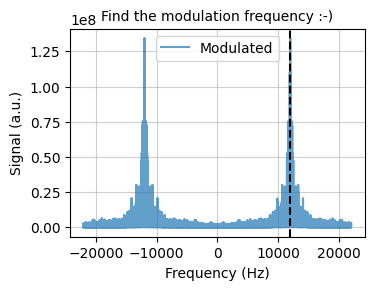

In [19]:
file_path = os.path.join(MOD_FOLDER, "am_song_04.wav")
sample_rate, modulated_signal = wavfile.read(file_path)
fft_data = fft(modulated_signal)
fft_freq = np.fft.fftfreq(len(modulated_signal), d=1/sample_rate)
plt.figure(figsize = (3.8, 2.7))
plt.plot(fft_freq, np.abs(fft_data), label = "Modulated", alpha = 0.7)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Signal (a.u.)")
mod_freq = 12000
bandwidth = 8000
plt.axvline(mod_freq,ls =  "--", color = "black")
plt.title("Find the modulation frequency :-)", fontsize = "medium")
plt.grid(True, alpha = 0.6)
plt.legend()
plt.show()

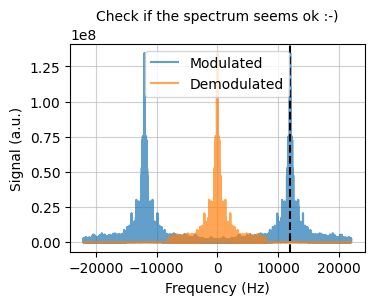

In [20]:
demodulated_data = demodulate(modulated_signal, sample_rate, mod_freq, bandwidth)
fft_demodulated_data = np.fft.fft(demodulated_data)
wavfile.write("output.wav", sample_rate, demodulated_data.real.astype(np.int16))
# Plot
plt.figure(figsize = (3.8, 2.7))
plt.plot(fft_freq, np.abs(fft_data), label = "Modulated", alpha = 0.7)
plt.plot(fft_freq, np.abs(fft_demodulated_data), label = "Demodulated", alpha = 0.7)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Signal (a.u.)")
plt.axvline(mod_freq,ls =  "--", color = "black")
plt.title("Check if the spectrum seems ok :-)", fontsize = "medium")
plt.grid(True, alpha = 0.6)
plt.legend()
plt.show()

# Fonction de test de mon code
Les fonction utilisées pour tester mon code.
## Test du code avec un la 440
Ci-dessous, je créee un signal avec un la 440, je le module puis le démodule et l'enregistre dans un fichier wav *output.wav*.

In [10]:
## Test avec un la 440
modulation_freq = 12000 # Hz
bandwidth = 8000 # Hz
sample_rate = 44100 # Hz
time = np.arange(0, 5,1/sample_rate) # 5 secondes de signal
signal = 10000 * np.sin(2*np.pi*440*time) # la 440 Hz
modulated_data = modulate(signal, sample_rate, modulation_freq = modulation_freq)
demodulated_data = 2*demodulate(modulated_data, sample_rate, modulation_freq = modulation_freq, bandwidth=bandwidth)

# sauvegarde du fichier modulé/démodulé pour voir si on entend bien un la 440
wavfile.write("output.wav", sample_rate, 2*demodulated_data.real.astype(np.int16))

/home/victor/.virtualenvs/vikenv/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/victor/.virtualenvs/vikenv/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


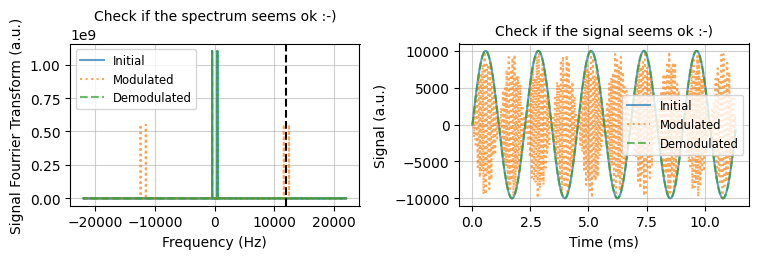

In [11]:
fft_data = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(signal), d=1/sample_rate)
fft_modulated_data = np.fft.fft(modulated_data)
fft_demodulated_data = np.fft.fft(demodulated_data)

# Plot
plt.figure(figsize = (3.8*2, 2.7))
plt.subplot(1,2,1)
plt.plot(fft_freq, np.abs(fft_data), label = "Initial", alpha = 0.7)
plt.plot(fft_freq, np.abs(fft_modulated_data),ls = ":", label = "Modulated", alpha = 0.7)
plt.plot(fft_freq, np.abs(fft_demodulated_data),ls = "--", label = "Demodulated", alpha = 0.7)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Signal Fourrier Transform (a.u.)")
plt.axvline(modulation_freq,ls =  "--", color = "black")
plt.title("Check if the spectrum seems ok :-)", fontsize = "medium")
plt.grid(True, alpha = 0.6)
plt.legend(fontsize = "small")
plt.subplot(1,2,2)
maxi = int(5/440*sample_rate)
plt.plot(time[0:maxi]*1e3, signal[0:maxi], label = "Initial", alpha = 0.7)
plt.plot(time[0:maxi]*1e3, modulated_data[0:maxi],ls = ":", label = "Modulated", alpha = 0.7)
plt.plot(time[0:maxi]*1e3, demodulated_data[0:maxi],ls = "--", label = "Demodulated", alpha = 0.7)
plt.title("Check if the signal seems ok :-)", fontsize = "medium")
plt.grid(True, alpha = 0.6)
plt.xlabel("Time (ms)")
plt.ylabel("Signal (a.u.)")
plt.legend(fontsize = "small")
plt.tight_layout()
plt.show()

## Test du code avec une *vrai* musique
On récupère un des fichiers initiaux, et on le module puis on le démodule.

In [14]:
## Test avec un la 440
modulation_freq = 12000 # Hz
bandwidth = 8000 # Hz
file_path = os.path.join(FOLDER, "pirates_des_caraibes.wav")
sample_rate, signal = load_wav_file(file_path)
modulated_data = modulate(signal, sample_rate, modulation_freq = modulation_freq)
demodulated_data = 2*demodulate(modulated_data, sample_rate, modulation_freq = modulation_freq, bandwidth=bandwidth)
# sauvegarde du fichier modulé/démodulé pour voir si on entend bien un la 440
wavfile.write("output.wav", sample_rate, demodulated_data.real.astype(np.int16))

## Test du code avec enregistrement d'un son entre temps
La dernière étape est de vérifier que lorsque j'enregistre entre temps mon signal modulé, je ne perd pas trop d'information.

In [17]:
modulation_freq = 12000 # Hz
bandwidth = 8000 # Hz
file_path = os.path.join(FOLDER, "harry_potter.wav")
sample_rate, signal = load_wav_file(file_path)
modulated_data = modulate(signal, sample_rate, modulation_freq = modulation_freq)
wavfile.write("test_modulated.wav", sample_rate, modulated_data.astype(np.int16))
# je charge maintenant le fichier
sample_rate, unknow_signal = load_wav_file("modulated.wav")
demodulated_data = 2*demodulate(unknow_signal, sample_rate, modulation_freq = modulation_freq, bandwidth=bandwidth)
wavfile.write("output.wav", sample_rate, demodulated_data.real.astype(np.int16))

In [217]:
def modulate_wave_file(folder, mod_folder, modulation_freq=12000, max_duration=15 ):
    """
    Parcourt aléatoireement l'ensemble des fichiers wav du dosser folder et mlodule les 
    max_duration premières secondes du signal à la fréquence modulation_freq.

    PARAMETERS
    -----------
    signal : array
        signal to be demodulated
    max_duration: float
        durée maximale en seconde du morceau
    modulation_freq: float
        modulation frequency in hertz (or that should match the unit of the sample rate)
    """
    # check modulation folder
    try:
        os.mkdir(mod_folder)
    except FileExistsError:
        pass
    wav_files = glob.glob(os.path.join(folder, "*.wav"))
    random.shuffle(wav_files)
    dico = {} # dictionary in which we will store the correspondance between unknown file and the music song
    for i, fn in enumerate(wav_files):
        # on récupère le nom de la chanson
        song_name = fn
        for s in [str(folder), os.path.sep, ".wav"]:
            song_name = song_name.replace(s, "")
        song_name = song_name.replace("_", " ").title()
        # Modulate signal
        sample_rate, data = load_fraction_of_music(fn, max_duration = max_duration)
        modulated_data = modulate(data, sample_rate, modulation_freq = modulation_freq)
        ## Save file
        # define the name of the secret modulated file
        am_file_name = "am_song_{:0>2d}".format(i)
        # store it for teachers
        dico[am_file_name] = song_name
        file_path = os.path.join(mod_folder,am_file_name + ".wav")
        wavfile.write(file_path, sample_rate, modulated_data)
        print(f"{file_path}  :   {song_name}")
    # on écrit dans un fichier la correspondance entre les fichiers mystères et le titre
    with open("correspondances.txt", "w") as file:
        for key, val in dico.items():
            file.write(key+ " : "+val+ "\n")


modulate_wave_file(FOLDER,MOD_FOLDER, modulation_freq = MODULATION_FREQ, max_duration = MAX_DURATION)

modulated_files/am_song_00.wav  :   Harry Potter
modulated_files/am_song_01.wav  :   Pirates Des Caraibes
modulated_files/am_song_02.wav  :   Star Wars
modulated_files/am_song_03.wav  :   Game Of Throne
modulated_files/am_song_04.wav  :   Indiana Jones
modulated_files/am_song_05.wav  :   Titanic
modulated_files/am_song_06.wav  :   Les Bronzes Font Du Ski
